In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['plates.zip', 'sample_submission.csv']
After zip extraction:
['plates', '__MACOSX', '__notebook_source__.ipynb', '.ipynb_checkpoints']


In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [3]:
# создаем dirty, clean в train, val
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        #if i % 5 != 0:
        dest_dir = os.path.join(train_dir, class_name)
        #else:
        #   dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3534.53it/s]


In [4]:
!ls train

cleaned  dirty


In [33]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from pathlib import Path
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensor

from torch.utils.data import Dataset, DataLoader
# Define the augmentation pipeline
train_augmentation = A.Compose(
    [
        A.CenterCrop(224, 224, p=0.7),
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Transpose(),
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p=0.5
        ),
        A.ChannelShuffle(p=0.5),
        A.RGBShift(r_shift_limit=127, g_shift_limit=127, b_shift_limit=127, p = 0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)


val_augmentation = A.Compose(
    [
        A.CenterCrop(224, 224, p=0.5),
        A.Resize(224, 224),
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Transpose(),
        A.CLAHE(p=1.),
        
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        
        ToTensor()
    ],
    p=1
)


class PlatesDataset(Dataset):

    def __init__(self, image_paths, augmentations = None, labels=None):
        super().__init__()
        self.image_paths = image_paths
        self.augmentations = augmentations
        self.size = len(image_paths)
        self.labels = labels

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        image = self.load_image(self.image_paths[idx])
        augmented = self.augmentations(image=image)
        if self.labels is not None:
            label = 1 if self.labels[idx] == 'dirty' else 0
            return augmented['image'], torch.LongTensor([label])
        return augmented['image']

    def load_image(self, image_path):
        image = Image.open(image_path)
        image.load()
        image = image.resize((224,224))
        return np.array(image)

BATCH_SIZE = 10

TRAIN_DIR = Path('plates/train')
TEST_DIR = Path('plates/test')

train_files = list(TRAIN_DIR.rglob('*.jpg'))

train_labels = [path.parent.name for path in train_files]
train_dataset = PlatesDataset(train_files, augmentations=train_augmentation, labels=train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=BATCH_SIZE)

val_dataset = PlatesDataset(train_files, augmentations=val_augmentation, labels=train_labels)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=BATCH_SIZE)

In [16]:
len(train_dataloader), len(train_dataset)

(4, 40)

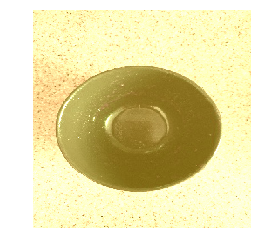

In [34]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.axis('off')
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

tensor(0)


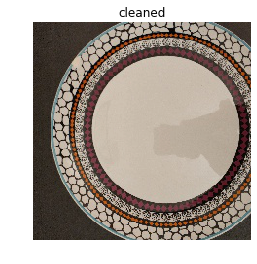

tensor(0)


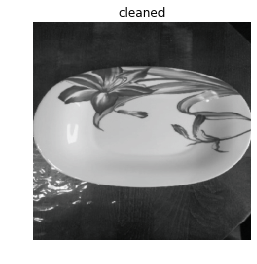

tensor(0)


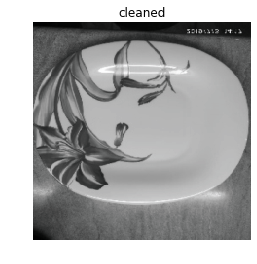

tensor(0)


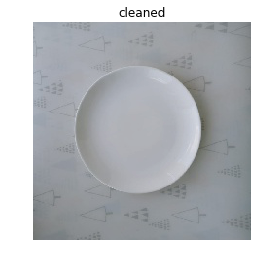

tensor(0)


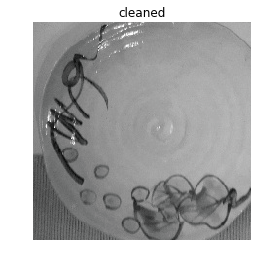

tensor(0)


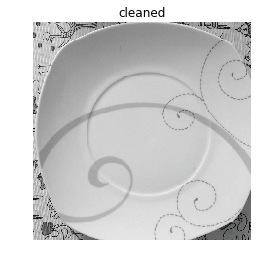

tensor(1)


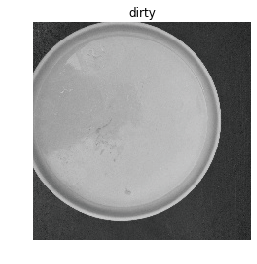

tensor(0)


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6cc0bfe438>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


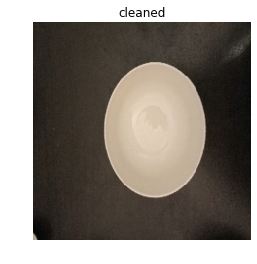

tensor(0)


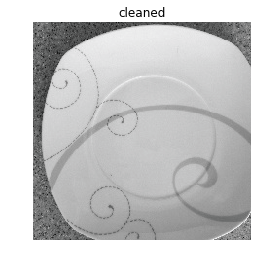

tensor(0)


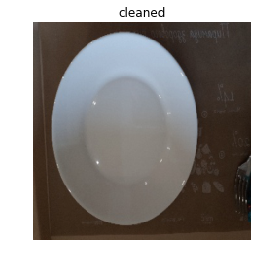

In [29]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    print(y_item)
    show_input(x_item, title=class_names[y_item])

In [40]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    loss_val_history = []
    loss_train_history = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.squeeze(1)
                #print(labels)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'train':
                loss_train_history.append(epoch_loss)
            else:
                loss_val_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return loss_train_history, loss_val_history

cuda:0
Epoch 0/99:
train Loss: 0.7452 Acc: 0.3750
val Loss: 0.7141 Acc: 0.5000
Epoch 1/99:
train Loss: 0.6896 Acc: 0.6250
val Loss: 0.7398 Acc: 0.5000
Epoch 2/99:
train Loss: 0.7487 Acc: 0.3750
val Loss: 0.6682 Acc: 0.5000
Epoch 3/99:
train Loss: 0.6475 Acc: 0.5500
val Loss: 0.6680 Acc: 0.5500
Epoch 4/99:
train Loss: 0.6693 Acc: 0.5000
val Loss: 0.5905 Acc: 0.8500
Epoch 5/99:
train Loss: 0.6442 Acc: 0.7500
val Loss: 0.6660 Acc: 0.5250
Epoch 6/99:
train Loss: 0.6561 Acc: 0.6000
val Loss: 0.6419 Acc: 0.5500
Epoch 7/99:
train Loss: 0.6316 Acc: 0.5750
val Loss: 0.6026 Acc: 0.6500
Epoch 8/99:
train Loss: 0.6036 Acc: 0.6250
val Loss: 0.6135 Acc: 0.6500
Epoch 9/99:
train Loss: 0.5931 Acc: 0.7750
val Loss: 0.5746 Acc: 0.7750
Epoch 10/99:
train Loss: 0.6026 Acc: 0.7250
val Loss: 0.5715 Acc: 0.8250
Epoch 11/99:
train Loss: 0.6005 Acc: 0.7500
val Loss: 0.5671 Acc: 0.8750
Epoch 12/99:
train Loss: 0.5832 Acc: 0.8250
val Loss: 0.5560 Acc: 0.8250
Epoch 13/99:
train Loss: 0.5786 Acc: 0.8750
val Loss: 

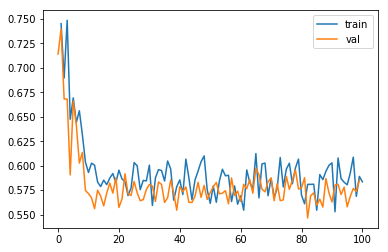

In [41]:
import torchvision.models as models
#resnet18 = models.resnet18(pretrained=True)
#resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)
#googlenet = models.googlenet(pretrained=True)
#ensemble = [resnet18, resnet50, googlenet, resnet152]
ensemble = [resnet152]

loss = torch.nn.CrossEntropyLoss()
num_epochs = 100

for model in ensemble:
    # Disable grad for all conv layers
    for name, param in model.named_parameters():
        param.requires_grad = False
        # batch normalization
        #if("bn" not in name):
        #    

    model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 2))
                                   #torch.nn.Linear(100, 2))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    # TRAIN
    loss_train_history = train_model(model, loss, optimizer, scheduler, num_epochs=num_epochs)
    # plot losses
    plt.plot(range(1,num_epochs + 1), *loss_train_history)#, loss_val_history)
    plt.legend(["train", "val"])
    plt.show()
    

In [43]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [47]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_transforms = A.Compose([
    ToTensor(),
    A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = ImageFolderWithPaths('/kaggle/working/test', test_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [48]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [49]:
for model in ensemble:
    model.eval()

test_predictions = []
test_img_paths = []

for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = ensemble[0](inputs)
        test_pred = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
        for model in ensemble[1:]:
            pred = model(inputs)
    test_predictions.append(test_pred)    
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)


 82%|████████▏ | 612/744 [00:18<00:04, 32.57it/s]


100%|██████████| 744/744 [00:22<00:00, 33.37it/s]

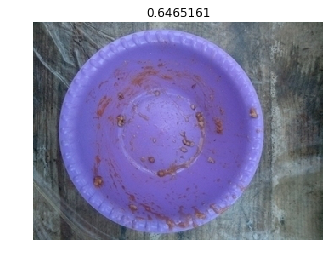

In [50]:
inputs, labels, paths = next(iter(test_dataloader))
for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [51]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [52]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [53]:
submission_df.to_csv('submission_2_layers.csv')

In [ ]:
!rm -rf test resnet152_2fc_layers resnet152_2fc_layers.pt submission_2_layers_val.csv

In [ ]:
torch.save(ensemble[0].state_dict(), 'resnet152_2fc_layers.pt')